In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow.keras
from tensorflow.keras.datasets import mnist

In [2]:
def importing(data):
    data=data.astype('float32')/255.0 # Normalize image vector
    data=np.array(data).reshape(-1,28,28,1) # reshape to 28*28 image with one RGB channel
    return data

In [3]:
(train_data, _), (test_data, _) = mnist.load_data()

In [4]:
train=importing(train_data)
test=importing(test_data)

In [5]:
def add_noise(array,noise_degree=0.5):
    noised_array=array+noise_degree*np.random.normal(size=array.shape)
    return np.clip(noised_array,0.0,1.0)

In [6]:
noised_array=add_noise(train)

In [7]:
def display_image(train_img, noise_img,sampling_size=10):
    plt.figure(figsize=(20,4))
    for i in range(sampling_size):
        idx = np.random.randint(len(train_img), size=1)
        ax = plt.subplot(2, sampling_size, i + 1)
        plt.imshow(train_img[idx].reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.gray()


        ax = plt.subplot(2, sampling_size, i + 1 + sampling_size)
        plt.imshow(noise_img[idx].reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.gray()
        
    plt.show()

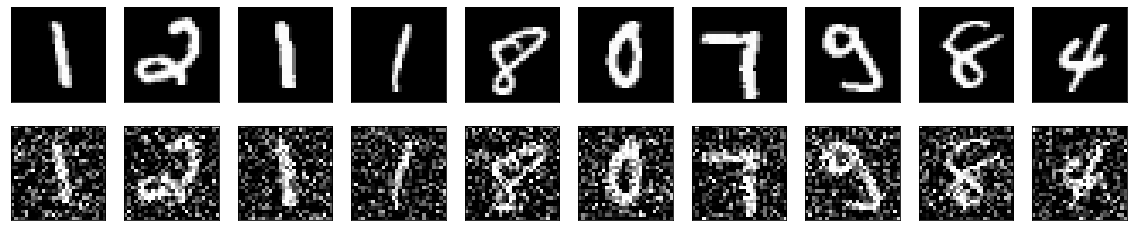

In [8]:
display_image(train,add_noise(train,0.4))

In [16]:
import torch
import torch.nn as nn


class autoencoder(nn.Module):

    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(32, 32, 3, padding=1),
                                     nn.ReLU())
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1), nn.Sigmoid())

    def forward(self, train_array):
        encoded = self.encoder(train_array)
        decoded = self.decoder(encoded)

        return decoded

In [17]:
from torch.utils.data import DataLoader
train=train.reshape(-1,1,28,28)
test=test.reshape(-1,1,28,28)

train_loader=DataLoader(train,batch_size=128,drop_last=True,num_workers=2)
test_loader=DataLoader(test,batch_size=128,drop_last=True,num_workers=2)

  0%|          | 0/100 [00:00<?, ?it/s]

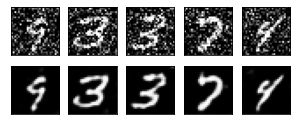

  1%|          | 1/100 [01:01<1:42:05, 61.87s/it]

==========Train Loss is 0.029173829117153063==========
==========Val Loss is 0.0017142818392946934==========


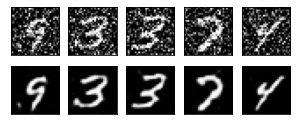

  2%|▏         | 2/100 [02:09<1:47:01, 65.53s/it]

==========Train Loss is 0.009870790384916795==========
==========Val Loss is 0.0015804170626892238==========


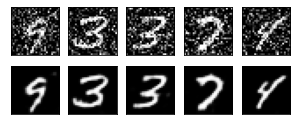

  3%|▎         | 3/100 [03:18<1:48:30, 67.11s/it]

==========Train Loss is 0.00933907794344247==========
==========Val Loss is 0.001511975959675689==========


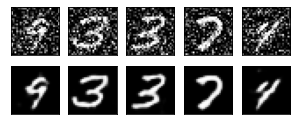

  4%|▍         | 4/100 [04:24<1:46:32, 66.59s/it]

==========Train Loss is 0.008999819795672711==========
==========Val Loss is 0.0014608061362981286==========


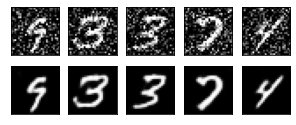

  5%|▌         | 5/100 [05:30<1:44:54, 66.25s/it]

==========Train Loss is 0.008740426265061475==========
==========Val Loss is 0.0014140114295654572==========


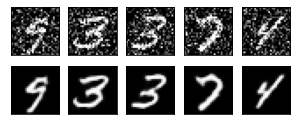

  6%|▌         | 6/100 [06:35<1:42:56, 65.71s/it]

==========Train Loss is 0.00852004692563389==========
==========Val Loss is 0.0013852242149539993==========


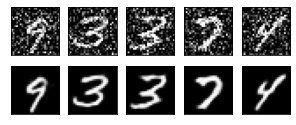

  7%|▋         | 7/100 [07:44<1:43:55, 67.05s/it]

==========Train Loss is 0.008339452306525065==========
==========Val Loss is 0.0013618573415069245==========


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000022F9F9BD430>
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "C:\Users\Administrator\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1445, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\Administrator\anaconda3\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\Administrator\anaconda3\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
  7%|▋         | 7/100 [08:29<1:52:54, 72.85s/it]


KeyboardInterrupt: 

In [18]:
from tqdm import tqdm 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.autograd import Variable

auto=autoencoder().to(device)

optimizer=torch.optim.Adam(auto.parameters())
criterion=torch.nn.MSELoss()

for epoch in tqdm(range(100)):
    record_trainloss=0
    record_valloss=0
    for xxtrain in train_loader:
        optimizer.zero_grad()
        
        xxtrain = xxtrain.view(-1, 1, 28, 28)
        xxtrain=xxtrain.to(device)

        xxtrain_noise=torch.clip(xxtrain+0.4*torch.normal(mean=0,std=1,size=xxtrain.shape).to(device),0.0,1.0)
        
        reconstruct=auto(xxtrain_noise)
        loss=criterion(xxtrain,reconstruct)
        loss.backward()
        optimizer.step()
        record_trainloss+=loss.item()
    auto.eval()
    
    with torch.no_grad():
        for xxval in test_loader:
            optimizer.zero_grad()
            xxval = xxval.view(-1, 1, 28, 28)

            xxval=xxval.to(device)
            xxval_noise=torch.clip(xxval+0.4*torch.normal(mean=0,std=1,size=xxval.shape).to(device),0.0,1.0)

            reconstruct_val=auto(xxval_noise)
            loss=criterion(xxval,reconstruct_val)
            record_valloss+=loss.item()
    auto.eval()

    fig,ax=plt.subplots(2,5,figsize=(5,2))
    for i in range(5):
        img=xxtrain_noise.cpu()[i].view(28,28)
        img_reconstructed=reconstruct.detach().cpu().numpy()[i].reshape(28,28)
            
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.gray()


        ax = plt.subplot(2, 5, i + 1 + 5)
        plt.imshow(img_reconstructed)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.gray()
    plt.savefig("./each_epoch/{}epoch.png".format(epoch))
    plt.show()
        
    
    print('==========Train Loss is {}=========='.format(record_trainloss/len(train_loader)))
    print('==========Val Loss is {}=========='.format(record_valloss/len(train_loader)))

In [69]:
img=(xxtrain.cpu()[i].view(28,28))

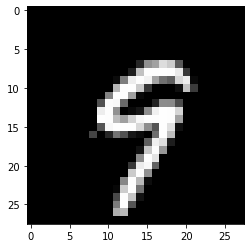

In [72]:
plt.imshow(img)